In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import scipy as sp

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from gitlab.client import Gitlab as gl
#import xgboost as xgb
import pickle


In [ ]:
def ShouldRunModels():
    try:
        value = gl.variables.get('run_models')
        if(value == 0):
            return False
        else:
            return True
    except:
        return False

run_mdls = ShouldRunModels()
# manually set if needed
run_mdls = True

print(run_mdls)

## Data import

In [ ]:
df_clean = pd.read_csv("../Analyse/df_clean.csv")
df_clean = df_clean.drop(columns=['Unnamed: 0'])
df_clean

In [ ]:
df_clean.dtypes

In [ ]:
df_clean['time'] = pd.to_datetime(df_clean['time'])

## data preparation

In [ ]:
df_clean['name'].value_counts()

In [ ]:
df_clean.columns

In [ ]:
df_clean.iloc[:, 3:18].hist(figsize=(22, 10), bins=50)
# tite wie?
plt.show()

Hier wird ersichtlich, dass keine der Varialben normalverteilt ist. Trotzdem wird in Folge versucht, Ausreisser mittels Boxplots zu itentifizieren.

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 8))
axs = axs.flatten()
for i in range(3):
    axs[i].set_title(["accelometer", "magnetometer", "gyroscope"][i])
    axs[i].boxplot(df_clean.iloc[:, i*3 + 3 : i*3 + 6])
    #axs[i] = sns.swarmplot(data=df_clean.iloc[:, i*3 + 3 : i*3 + 6], color="grey")

axs[3].set_title("orientation")
axs[3].boxplot(df_clean.iloc[:, 12:16])
# axs[4].set_title("gps")
# axs[4].boxplot(df_clean.iloc[:, 16:18])

fig.suptitle("Verteilung numerischer Daten")

plt.show()

## Aggregation

Um die Achsen der Daten im Modell nicht einzubeziehen sollen diese miteinander verrechnet werden. Dafür machen wir die Werte positiv und addieren sie auf. Da alle Achsen gleich skaliert werden sollen, wird anstelle einer Normailsierung mit einem konstanten Wert addiert.

In [ ]:
# accelometer
df_clean['acc'] = (df_clean.iloc[:, 3:6] + 10).sum(axis=1)
# magnetometer
df_clean['mag'] = (df_clean.iloc[:, 6:9] + 2000).sum(axis=1)
# gyroscope
df_clean['gyr'] = (df_clean.iloc[:, 9:12] + 30).sum(axis=1)
# orientation
df_clean['ori'] = (df_clean.iloc[:, 12:16] + 1).sum(axis=1)

# drop old axis columns
df_clean.drop(columns=df_clean.columns[3:16], inplace=True)
df_clean.columns

In [ ]:
(df_clean.iloc[:, 3:] < 0).sum()

Wie hier sichtbar wird sind keine negativen Sensorwerte mehr vorhanden. Dies ist gut so.

In [ ]:
df_clean.iloc[:, 3:].hist(figsize=(22, 7), bins=50)
plt.show()

Sinnvoller als Koordinatendaten wäre Geschwindigkeit. Denn auf den Ort soll nicht zurückgeschlossen werden. Dafür werden hier die Koordinaten Unterschiede berechnet.

In [ ]:
gps_diff = (df_clean.loc[:, ["lat", "long"]] - df_clean.loc[:, ["lat", "long"]].shift(-1))
gps_diff.replace(0, np.NAN, inplace=True)
gps_diff[(abs(gps_diff) < 1e-3)].hist(bins=50, figsize=(22, 5))

plt.show()

Werte ausserhalb diese Bereichs werden als Ausreisser betrachtet und deshalb hier entfernt.

In [ ]:
gps_diff[abs(gps_diff) > 1e-3] = np.NAN
gps_diff.describe()

In [ ]:
gps_diff.notna().sum()

In [ ]:
df_clean["gps_differs"] = (df_clean[["lat", "long"]] - df_clean[["lat", "long"]].shift(-1)).sum(axis=1).astype(bool)
df_clean["gps_differs"].value_counts()

In [ ]:
# calculate distance in meters (https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python)

i = 0

def get_distance(point1, point2):
    if(point1[0] == point2[0] and point1[1] == point2[1]):
        return 0.0

    R = 6370
    lat1 = radians(point1[0])  #insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

dists = []
gps_differs_index = df_clean.loc[df_clean["gps_differs"] == True, "gps_differs"].index
for i in range(gps_differs_index.shape[0]):
    dists.append(get_distance(df_clean.loc[gps_differs_index[i], ["lat", "long"]], df_clean.loc[gps_differs_index[i]+1, ["lat", "long"]]))

    i = i+1
    if(i % 10000 == 0):
        print(f"{round(i/gps_differs_index.shape[0] * 100)}%")

len(dists)

In [ ]:
# Verteilung der dists
dists = pd.Series(dists)
dists[(dists < 1)].hist(bins=50)
plt.show()

In [ ]:
# calculate time differences
time_differences = pd.Series(df_clean.loc[gps_differs_index, "time"].values - df_clean.loc[gps_differs_index.insert(0, 0)[:-1], "time"].values)
time_diff_secs = time_differences.dt.total_seconds()

time_diff_secs[(time_diff_secs < 15) & (time_diff_secs > -10)].hist(bins=50)
plt.show()

Das Zeitintervall der GPS Messungen ist etwa 1s. Um falsche Werte zu verwerfen werden diese auf 0 gesetzt, später durch 0 dividiert.

In [ ]:
print(time_diff_secs[(time_diff_secs > 15) | (time_diff_secs < -10)].shape)
time_diff_secs.loc[(time_diff_secs > 10) | (time_diff_secs < 0)] = 0.0

In [ ]:
# m/s ausrechen, in km/h umrechnen
kmh = (dists / time_diff_secs * 3.6)
kmh[kmh == np.inf] = np.nan
kmh[kmh > 120] = np.nan
kmh[kmh < 1] = 0
kmh[kmh > 0].hist(bins=50)
plt.show()

In [ ]:
# geschwindigkeit inseriteren
df_clean.loc[gps_differs_index, "kmh"] = kmh
df_clean.drop(columns=["lat", "long", "gps_differs"], inplace=True)
df_clean

In [ ]:
# forward fill
df_clean["kmh"] = df_clean["kmh"].ffill().fillna(0)
df_clean.hist(figsize=(22, 7), bins=50)
plt.show()

# Filter nach 5sec Abschnitte

In [ ]:
old_time = pd.to_datetime("01.01.2021 00:00:00")

df_clean["5s_index"] = (df_clean["time"] - old_time).dt.total_seconds() // 5 * 5
# df_clean["5s_index"].value_counts()

In [ ]:
df_wind = df_clean.groupby("5s_index")
# print group count
print(df_wind.size().count())
# count elements per group
df_wind.size().hist(figsize=(22, 5), bins=50)
plt.show()

Als nächstes wird geprüft, ob Elemente mit mehreren Namen existieren, sich dieser also in 5s geändert hat. Diese werden in Folge entfernt, da es nur wenige Werte sind.

In [ ]:
df_wind["name"].nunique().value_counts()

In [ ]:
print(df_wind.size().count())
df_wind = df_wind.filter(lambda g: g["name"].nunique() == 1).groupby("5s_index")
print(df_wind.size().count())

In [ ]:
df_clean.columns[3:8].values

In [ ]:
target = df_wind[["name", "activity"]].first().reset_index()
target

In [ ]:
df_agg = df_wind[df_clean.columns[3:8]].agg(["var", "mean", "median", "min", "max"]).reset_index()
np.array(df_agg.columns)

In [ ]:
# flatten mutli index columns
df_agg.columns = ['_'.join(column) for column in df_agg.columns]
df_agg.columns

In [ ]:
# add target variables
if("activity" not in df_agg.columns):
    df_agg = pd.concat([df_agg, target], axis=1)
df_agg.columns

In [ ]:
df_agg.iloc[:, :-2].columns

In [ ]:
#  check for NA's
df_agg.isna().sum()[df_agg.isna().sum() > 0]

In [ ]:
df_agg = df_agg.drop(columns=["5s_index_", "5s_index"])

In [ ]:
# Inputation von 0, da Varianz 0 keine Varianz darstellt.
df_agg = df_agg.fillna(0)

In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(df_agg.iloc[:, :-2], df_agg["activity"], test_size=0.2, random_state=42)

In [ ]:
if(run_mdls):
    log_range = np.logspace(0, 3, 10) / 1e+3 / 1
    model = RandomForestClassifier(n_jobs = -1, oob_score=True, warm_start=True)
    param_grid = {
        'n_estimators': [200, 250, 300],
        'max_depth': [30, 35, 40],
        'ccp_alpha': list(log_range / 100),
    }
    # scoring definition from https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='f1_weighted', n_iter=10, verbose=1, random_state=42)
    # fit on all data
    rs.fit(X_train, y_train)

else:
    rs = pickle.load(open('../models/rf_allprop.pkl', 'rb'))

print("")
print(f'Random Forest refit weighted f1:        {rs.score(X_test, y_test)}')
print(f'Random Forest best cv mean weighted f1: {rs.best_score_}')
print(f'Random Forest best parameters:          {rs.best_estimator_}')

In [ ]:
def plot_confusion(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.8)
    for row in range(conf_matrix.shape[0]):
        for col in range(conf_matrix.shape[1]):
            ax.text(x=col, y = row, s = conf_matrix[row, col], va='center', ha='center', size='xx-large')

    ax.tick_params(axis="x", rotation=30)
    classes = np.unique(df_agg["activity"].unique())
    plt.xticks(np.arange(0,len(classes)), classes)
    plt.yticks(np.arange(0,len(classes)), classes)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.colorbar(im, shrink=0.825)
    plt.show()

plot_confusion(y_test, rs.predict(X_test))

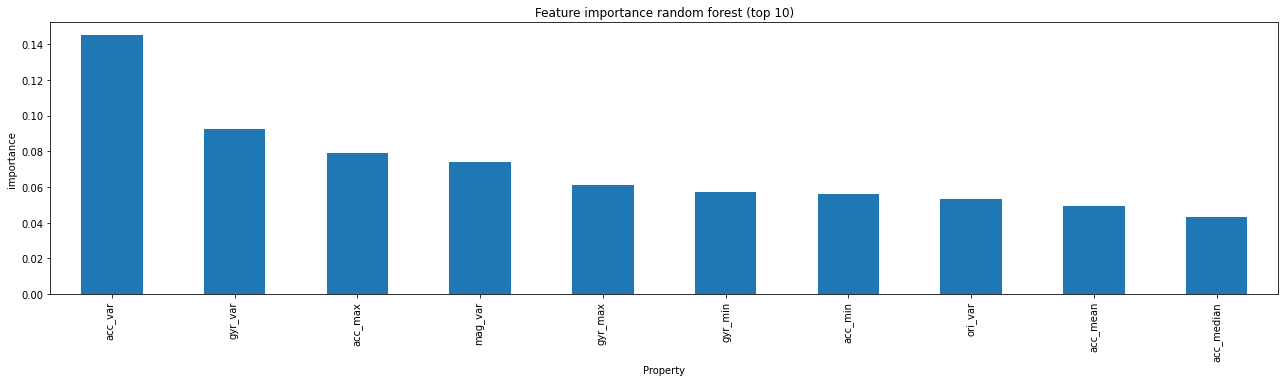

In [52]:
importances = pd.Series(rs.best_estimator_.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
importances[0:10].plot(kind='bar', figsize=(22, 5))
plt.title("Feature importance random forest (top 10)")
plt.xlabel("Property")
plt.ylabel("importance")
plt.show()

Hier wird deutlich, dass Varianzen den grössten Einfluss auf den Activity Typ haben. Der Accelometer und der Gyroskopsensor scheinen den grössten Einfluss zu haben.